In [55]:
import pandas as pd
import numpy as np
from PIL import Image

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

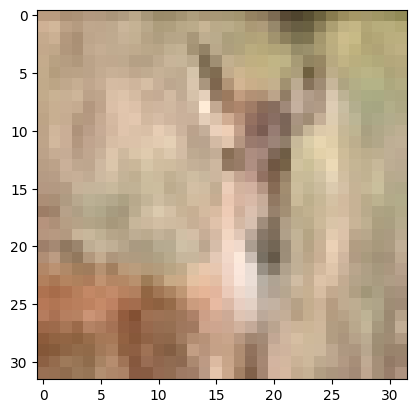

In [56]:
ftype = "test"
fn = "ffc43a6.jpg"

img = Image.open(f"{ftype}_ims/{fn}")
plt.imshow(img)

In [57]:
def read_data(mode="train", p=0.2, seed=None):
    """
    Read the training/testing files and return the input data and labels.

    Parameters:
    ----------
    mode (str): 'train' or 'test' to read the training or testing data.
    p (float): fraction of the data to read. Useful for debugging.
    seed (int): random seed to use for reproducibility.

    Returns:
    -------
    X (np.array): input data
    y (np.array): labels
    """
    if mode == "train" or mode == "test":
        data = pd.read_csv('train.csv')
        mode = "train"
    elif mode == "predict":
        data = pd.read_csv('test.csv')
        mode = "test"
    else:
        raise ValueError("mode must be 'train' or 'test' or 'predict'")

    if seed is None:data = data.sample(frac=p)
    else: data = data.sample(frac=p, random_state=seed)

    X = data['im_name'].apply(lambda filename: np.asarray(Image.open(f"{mode}_ims/{filename}"))).values
    y = data['label'].values
    X = np.stack(X).reshape(-1, 32*32*3)

    return X, y

In [58]:
trainData, trainLabels = read_data("train", p=0.2, seed=69)
testData, testLabels = read_data("test", p=0.02, seed=69)
trainData.shape, trainLabels.shape, testData.shape, testLabels.shape

KeyboardInterrupt: 

In [ ]:
trainData_red = trainData.reshape(-1, 32, 32, 3)[:, :, :, 0].reshape(-1, 32*32)
trainData_green = trainData.reshape(-1, 32, 32, 3)[:, :, :, 1].reshape(-1, 32*32)
trainData_blue = trainData.reshape(-1, 32, 32, 3)[:, :, :, 2].reshape(-1, 32*32)
trainData_greyScale = 0.2989 * trainData_red + 0.5870 * trainData_green + 0.1140 * trainData_blue
trainData_bg = 0.5 * trainData_blue + 0.5 * trainData_green

testData_red = testData.reshape(-1, 32, 32, 3)[:, :, :, 0].reshape(-1, 32*32)
testData_green = testData.reshape(-1, 32, 32, 3)[:, :, :, 1].reshape(-1, 32*32)
testData_blue = testData.reshape(-1, 32, 32, 3)[:, :, :, 2].reshape(-1, 32*32)
testData_greyScale = 0.2989 * testData_red + 0.5870 * testData_green + 0.1140 * testData_blue
testData_bg = 0.5 * testData_blue + 0.5 * testData_green

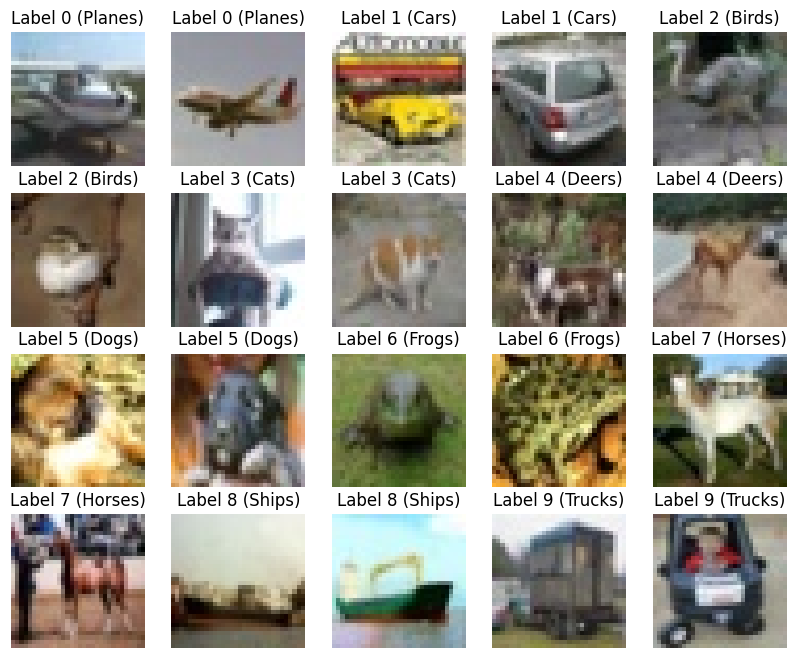

In [ ]:
# Plot 2 sample images from the training set from each label
i2label = ["Planes", "Cars", "Birds", "Cats", "Deers", "Dogs", "Frogs", "Horses", "Ships", "Trucks"]
fig, ax = plt.subplots(4, 5, figsize=(10, 8))
for i in range(20):
    ax[i//5, i%5].imshow(trainData[trainLabels == i//2][i%2].reshape(32, 32, 3))
    ax[i//5, i%5].set_title(f"Label {i//2} ({i2label[i//2]})")
    ax[i//5, i%5].axis('off')

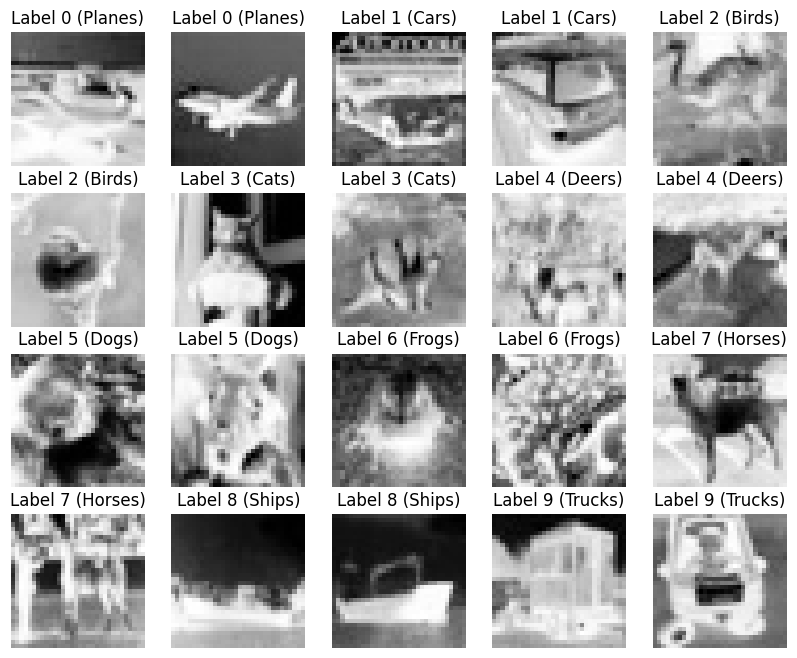

In [ ]:
# Plot 2 sample images from the training set from each label (only red)
fig, ax = plt.subplots(4, 5, figsize=(10, 8))
for i in range(20):
    ax[i//5, i%5].imshow(trainData_greyScale[trainLabels == i//2][i%2].reshape(32, 32), cmap='Greys')
    ax[i//5, i%5].set_title(f"Label {i//2} ({i2label[i//2]})")
    ax[i//5, i%5].axis('off')

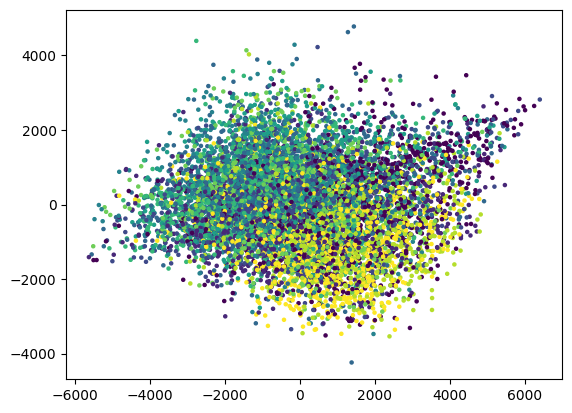

In [ ]:
# Use T-SNE to visualize the data
pca = PCA(n_components=2)
trainData_pca = pca.fit_transform(trainData)
plt.scatter(trainData_pca[:, 0], trainData_pca[:, 1], c=trainLabels, cmap='viridis', s=5)

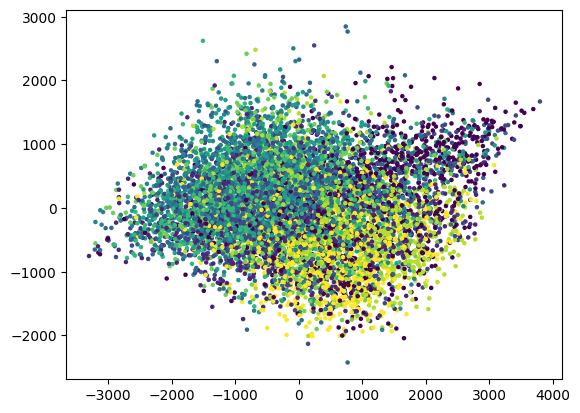

In [ ]:
# Use T-SNE to visualize the data (only red)
pcs = PCA(n_components=2)
trainData_pca = pcs.fit_transform(0.5*trainData_blue + 0.5*trainData_green)
plt.scatter(trainData_pca[:, 0], trainData_pca[:, 1], c=trainLabels, cmap='viridis', s=5)

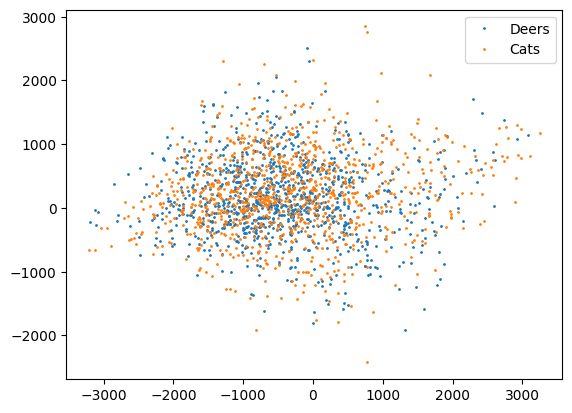

In [ ]:
# Split the labels into 2 groups, then visualize it
group1 = [4]
group2 = [3]
tr1 = sum([trainLabels == i for i in group1])
tr2 = sum([trainLabels == i for i in group2])
plt.plot(trainData_pca[tr1 == 1, 0], trainData_pca[tr1 == 1, 1], '.', label=', '.join(i2label[i] for i in group1), markersize=2)
plt.plot(trainData_pca[tr2 == 1, 0], trainData_pca[tr2 == 1, 1], '.', label=', '.join(i2label[i] for i in group2), markersize=2)
plt.legend()

In [ ]:
def getBinaryClassifier(model, trainData, trainLabels, group1, group2, testData=None, testLabels=None):
    """
    Fits a binary classifier that distinguishes between the two groups of labels.

    Parameters:
    ----------
    model (any): a learning model
    group1 (list): list of labels to group together
    group2 (list): list of labels to group together
    seed (int): random seed to use for reproducibility.

    Returns:
    -------
    clf (any): the trained classifier
    filteredData (np.array): the data used to train the classifier
    filteredLabels (np.array): the labels used to train the classifier
    """
    assert len(group1), "Group 1 must not be empty"
    assert len(group2), "Group 2 must not be empty"
    assert all([i not in group2 for i in group1]), "Two groups must not overlap"
    assert trainData.shape[0] == trainLabels.shape[0], "Data and labels must have the same length"

    filteredData = trainData[np.isin(trainLabels, group1 + group2)]
    filteredLabels = trainLabels[np.isin(trainLabels, group1 + group2)]
    filteredLabels = np.where(np.isin(filteredLabels, group1), 0, 1)

    pca = PCA(n_components=40)
    filteredData = pca.fit_transform(filteredData)

    clf = model
    clf.fit(filteredData, filteredLabels)
    train_scores = cross_val_score(clf, filteredData, filteredLabels, cv=5)
    train_acc = (clf.predict(filteredData) == filteredLabels).mean()
    
    if testData is not None and testLabels is not None:
        assert testData.shape[0] == testLabels.shape[0], "Data and labels must have the same length"
        testData = testData[np.isin(testLabels, group1 + group2)]
        testLabels = testLabels[np.isin(testLabels, group1 + group2)]
        testLabels = np.where(np.isin(testLabels, group1), 0, 1)
        
        testData = pca.transform(testData)
        
        test_scores = cross_val_score(clf, testData, testLabels, cv=5)
        test_acc = (clf.predict(testData) == testLabels).mean()
    
    print(f"Train scores: {train_scores.mean():.4f} +/- {train_scores.std():.4f}, Train accuracy: {train_acc:.4f}")
    if testData is not None and testLabels is not None:
        print(f"Test scores: {test_scores.mean():.4f} +/- {test_scores.std():.4f}, Test accuracy: {test_acc:.4f}")
    
    return clf, filteredData, filteredLabels

In [59]:
def plotDB(model, data, label, text_label, eps=1, smooth=True):
    """
    Plot the decision boundary of a binary model.

    Parameters:
    ----------
    model (any): a trained model
    data (np.array): input data
    label (np.array): labels
    i2label (list): list of labels that will be displayed on the plot
    eps (float): epsilon for the meshgrid
    smooth (bool): whether to plot the decision boundary smoothly

    Returns:
    -------
    None
    """
    assert data.shape[0] == label.shape[0]

    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data)

    x_min, x_max = data_pca[:, 0].min() - 4*eps, data_pca[:, 0].max() + 4*eps
    y_min, y_max = data_pca[:, 1].min() - 4*eps, data_pca[:, 1].max() + 4*eps
    xx, yy = np.meshgrid(np.arange(x_min, x_max, eps), np.arange(y_min, y_max, eps))
    if smooth: Z = model.predict_proba(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))[:, 0]
    else: Z = model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8, colors=["#FFA07A", "#87CEFA"], levels=[0, 0.5, 1])
    for i, l in enumerate(np.unique(label.astype(np.int32))): 
        plt.scatter(data_pca[label == l, 0], data_pca[label == l, 1], label=text_label[i], s=2)
    plt.contour(xx, yy, Z, levels=[0.5])
    plt.legend()
    plt.show()

In [63]:
# Find an optimal hyperparameter for SVM

pca = PCA(n_components=40)
size = 2000
trainData_pca_svm = pca.fit_transform(trainData_blue[:size])
trainLabels_svm = trainLabels[:size]

print("dim reduced to 40")

Cs = [0.01, 0.1, 1, 10, 100]

group = [0, 1, 8, 9]

tr = np.zeros(trainLabels_svm.shape)
for i in group:
    tr += (trainLabels_svm == i)

for C in Cs:
    svm = SVC(C=C, kernel='rbf')
    svm.fit(trainData_pca_svm, tr)
    scores = cross_val_score(svm, trainData_pca_svm, tr, cv=5)  # 5-fold cross-validation
    print(f"C={C}, Accuracy: {scores.mean():.4f} (+/- {scores.std()*2:.4f})")

"""
Conclusion: C=1 is optimal
"""

dim reduced to 40
C=0.01, Accuracy: 0.6740 (+/- 0.0117)
C=0.1, Accuracy: 0.7555 (+/- 0.0394)
C=1, Accuracy: 0.7850 (+/- 0.0207)
C=10, Accuracy: 0.7720 (+/- 0.0124)
C=100, Accuracy: 0.7665 (+/- 0.0186)


'\nConclusion: C=1 is optimal\n'

Train scores: 0.8218 +/- 0.0060, Train accuracy: 0.8631
Test scores: 0.7860 +/- 0.0242, Test accuracy: 0.8620


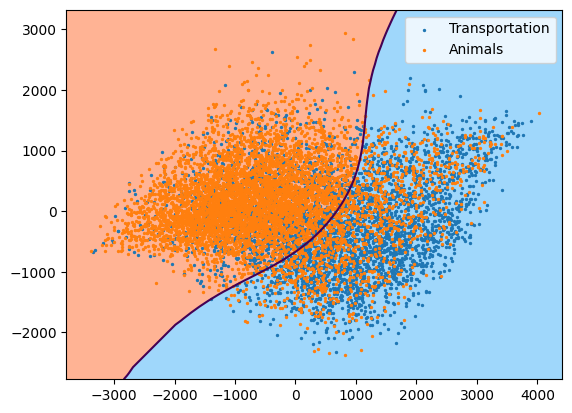

In [61]:
svm_animals2transportation, filtered_trainData, filtered_trainLabels = getBinaryClassifier(SVC(C=1, kernel='rbf', probability=True, random_state=69), 
                                                                                           trainData_blue, 
                                                                                           trainLabels, 
                                                                                           group1=[0, 1, 8, 9], 
                                                                                           group2=[2, 3, 4, 5, 6, 7],
                                                                                           testData=testData_blue,
                                                                                           testLabels=testLabels)
plotDB(svm_animals2transportation, filtered_trainData, filtered_trainLabels, ["Transportation", "Animals"], eps=100)


Train scores: 0.7184 +/- 0.0302, Train accuracy: 0.8197
Test scores: 0.6334 +/- 0.0578, Test accuracy: 0.7971


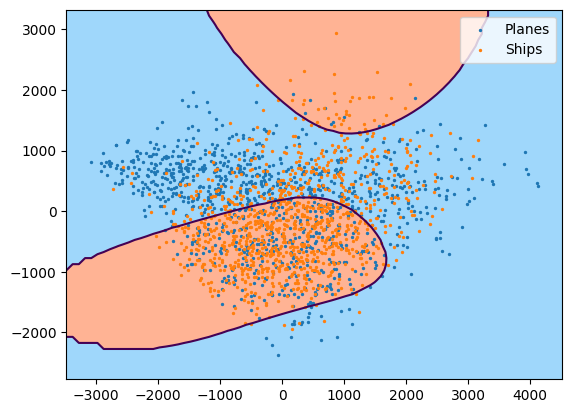

In [62]:
svm_airplane2ships, filtered_trainData, filtered_trainLabels = getBinaryClassifier(SVC(C=1, kernel='rbf', probability=True, random_state=69),
                                                                                       trainData_blue, 
                                                                                       trainLabels, 
                                                                                       group1=[0], 
                                                                                       group2=[8],
                                                                                       testData=testData_blue,
                                                                                       testLabels=testLabels)
plotDB(svm_airplane2ships, filtered_trainData, filtered_trainLabels, ["Planes", "Ships"], eps=100)

Train scores: 0.6055 +/- 0.0196, Train accuracy: 0.7691
Test scores: 0.5622 +/- 0.0760, Test accuracy: 0.7680


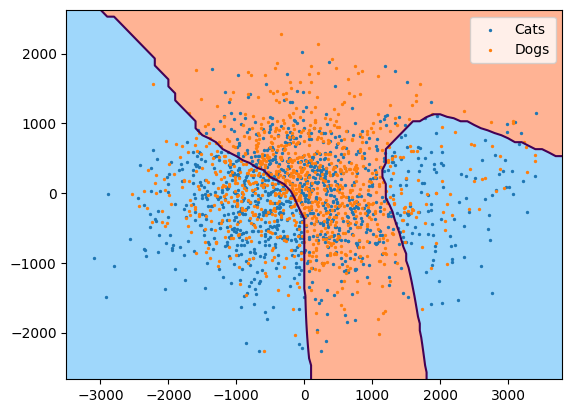

In [66]:
svm_cats2dogs, filtered_trainData, filtered_trainLabels = getBinaryClassifier(SVC(C=1, kernel='rbf', probability=True, random_state=69),
                                                                                       trainData_greyScale, 
                                                                                       trainLabels, 
                                                                                       group1=[3], 
                                                                                       group2=[5],
                                                                                       testData=testData_greyScale,
                                                                                       testLabels=testLabels)
plotDB(svm_cats2dogs, filtered_trainData, filtered_trainLabels, ["Cats", "Dogs"], eps=100)